In [1]:
import numpy as np
import pandas as pd
from nltk.util import ngrams
from os import listdir
from os.path import isfile, join
import json
import time
import nltk
import re
from progressbar import ProgressBar
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import regexp_tokenize
import nltk.data 
import matplotlib.pyplot as plt
import pickle
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import operator
import gensim
from gensim.models import word2vec
import logging
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer 

%matplotlib inline

C:\Users\surta\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# To use sentence and word tokenizers later
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\surta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\surta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\surta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
with open('C:/Users/surta/Downloads/preprocessed_final_with_dot.txt', 'r', encoding="utf8") as f:
    pre_text = f.readlines()

In [4]:
# Considering first 10,000 documents 

pre_text = pre_text[:10000]

In [5]:
# As Stated in COALS Algorithm, columns representing low-frequency words tend to be noisier. 
# Hence we consider 14,000 columns representing high-frequency words.
# For this purpose, we have TF-IDF to find such words.

vectorizer = TfidfVectorizer() 
tfidf = vectorizer.fit(pre_text) 
idf_scores = tfidf.idf_

feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(idf_scores)

n = 14000
top_n = feature_array[tfidf_sorting][:n]

In [6]:
# High freqeuncy words
top_n

array(['also', 'study', 'may', ..., 'outdated', 'dock', 'outgrowth'],
      dtype='<U155')

In [8]:
filtered_text_list =filtered_text_list = []
for text in tqdm(pre_text):
    text_word_list = [word for word in text.split() if word in top_n]
    filtered_text_list.append(' '.join(text_word_list))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:38<00:00,  1.00it/s]


In [7]:
with open('preprocessed_clean_final.txt', 'w', encoding = "utf8") as f:
    for item in tqdm(range(len(pre_text))):
        if item != '':
            # temp = ' '.join(item.split())
            # to keep one line space between documents
            f.write("%s\n" % ' '.join([word for word in pre_text[item].split(" ") if word in top_n]))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:25:02<00:00,  1.96it/s]


In [11]:
with open('C:/Users/surta/Downloads/preprocessed_clean_final.txt', 'r', encoding="utf8") as f:
    filtered_text_list = f.readlines()

In [7]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    
   
    corpus_words = sorted(list(set([word for words_list in corpus for word in words_list.split()])))
    num_corpus_words = len(corpus_words)
        
    # ------------------

    return corpus_words, num_corpus_words

### Co-occurence Matrix with a fixed window size

In [8]:
# Computing the co-occurence matrix with a default wi
ndow size = 4

def compute_co_occurrence_matrix(corpus, window_size = 4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}

    M = np.zeros((num_words, num_words))
    word2Ind = dict(zip(words, range(num_words)))
    for doc in tqdm(corpus):
        current_idx = 0
        words = doc.split(" ")
        doc_len = len(words)
        while current_idx < doc_len:
            left_boudary = max(current_idx - window_size, 0)
            right_boundary = min(current_idx + window_size + 1, doc_len)
            outside_words = " ".join(words[left_boudary:current_idx]) +" "+" ".join(words[current_idx+1:right_boundary])
            center_word = words[current_idx].strip()
            if center_word != '':
                center_idx = word2Ind[center_word]
            
            outside_words_split = outside_words.strip().split(" ")

            for outside_word in outside_words_split:
                if outside_word != '':
                    outside_idx = word2Ind[outside_word]
                    M[outside_idx, center_idx] += 1
            
            current_idx += 1
            
    return M, word2Ind

In [12]:
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(filtered_text_list)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:04<00:00, 80.48it/s]


In [13]:
M_co_occurrence

array([[8.100e+02, 8.000e+00, 4.000e+01, ..., 1.100e+01, 5.000e+00,
        4.000e+00],
       [8.000e+00, 1.020e+02, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [4.000e+01, 0.000e+00, 7.280e+02, ..., 4.000e+00, 1.000e+00,
        3.000e+00],
       ...,
       [1.100e+01, 0.000e+00, 4.000e+00, ..., 3.140e+02, 1.500e+01,
        2.200e+01],
       [5.000e+00, 0.000e+00, 1.000e+00, ..., 1.500e+01, 8.060e+02,
        9.500e+01],
       [4.000e+00, 0.000e+00, 3.000e+00, ..., 2.200e+01, 9.500e+01,
        1.098e+03]])

### Computing correlation matrix

In [14]:
def compute_correlation_matrix(C):
    """Tranform a counts matrix to correlation matrix.
    
    Args:
      C: co-occurence matrix of counts C_ij
    
    Returns:
      scipy.sparse.csc_matrix
    """
    # Total count
    Z = float(C.sum())

    # Sum each row (along columns)
    Zr = np.array(C.sum(axis=1), dtype=np.float64).flatten()
    
    # Get indices of relevant elements
    ii, jj = C.nonzero()  # row, column indices
    Cij = np.array(C[ii,jj], dtype=np.float64).flatten()
    
    # Correlation equation.
    corr = ((Cij * Z)-(Zr[ii] * Zr[jj]))/np.sqrt(Zr[ii]*(Z - Zr[ii])*(Zr[jj]*(Z - Zr[jj])))

    # Truncate to positive only
    ppmi = np.maximum(0, corr)  # take positive only
    
    # Re-format as sparse matrix
    ret = scipy.sparse.csc_matrix((ppmi, (ii,jj)), shape=C.shape,
                                  dtype=np.float64)
    ret.eliminate_zeros()  # remove zeros
    
    return ret


In [15]:
M_corr = compute_correlation_matrix(M_co_occurrence)

In [16]:
M_corr.toarray()

array([[4.50180520e-02, 1.39333550e-03, 1.85350250e-03, ...,
        8.88838647e-04, 1.80120613e-04, 1.02495902e-04],
       [1.39333550e-03, 5.84754778e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.85350250e-03, 0.00000000e+00, 3.20432797e-02, ...,
        2.28169165e-04, 0.00000000e+00, 1.45792239e-05],
       ...,
       [8.88838647e-04, 0.00000000e+00, 2.28169165e-04, ...,
        4.31992038e-02, 1.30711097e-03, 1.83629274e-03],
       [1.80120613e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.30711097e-03, 4.93128849e-02, 5.39497458e-03],
       [1.02495902e-04, 0.00000000e+00, 1.45792239e-05, ...,
        1.83629274e-03, 5.39497458e-03, 6.00784044e-02]])

### COAL + SVD

In [17]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 1     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    svd = TruncatedSVD(n_components = k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
        
    return M_reduced

In [18]:
M_reduced_co_occurrence = reduce_to_k_dim(M_corr.toarray(), k = 50)

Running Truncated SVD over 13356 words...


In [47]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """
    x_coords = M_reduced[:, 0]
    y_coords = M_reduced[:, 1]
    for word in words:
        idx = word2Ind[word]
        embedding = M_reduced[idx]
        x = embedding[0]
        y = embedding[1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize = 9)
        plt.title("Plot visualizing word embeddings from COAL+SVD")
    # ------------------

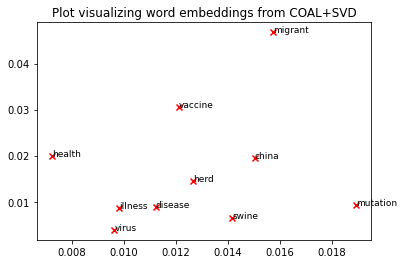

In [48]:
# Rescale (normalize) the rows to make them each of unit-length

M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis = 1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['vaccine', 'china', 'mutation', 'virus', 'health', 'disease', 'swine', 'migrant', 'herd', 'illness']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

## Building Word2Vec model


In [22]:
CONTEXT_SIZE = 3

ngrams = []
for doc in tqdm(filtered_text_list):
    words = doc.split()
    for i in range(len(words) - CONTEXT_SIZE):
        tup = [words[j] for j in np.arange(i , i + CONTEXT_SIZE) ]
        ngrams.append((tup, words[i + CONTEXT_SIZE]))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:02<00:00, 161.12it/s]


In [23]:
vocab,_ = distinct_words(filtered_text_list)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import urllib.request
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

torch.manual_seed(1)

EMBEDDING_DIM = 50
num_epochs = 100

class CBOWModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOWModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))  # -1 implies size inferred for that index from the size of the data
        out1 = F.relu(self.linear1(embeds)) # output of first layer
        out2 = self.linear2(out1)           # output of second layer
        log_probs = F.log_softmax(out2, dim=1)
        return log_probs

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)
            
losses = []
loss_function = nn.NLLLoss()
model = CBOWModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr = 0.001)

# Initializing Word2Vec embedding matrix with with the word vectors estimated using COALS-SVD
with torch.no_grad():
    for i in range(len(vocab)):
        model.embeddings.weight[i] = torch.from_numpy(M_reduced_co_occurrence)[i]

for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for context, target in ngrams[:1000]:

        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        model.zero_grad()
        
        log_probs = model(context_idxs)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    #print(total_loss)
    losses.append(total_loss)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [19:33<00:00, 11.74s/it]


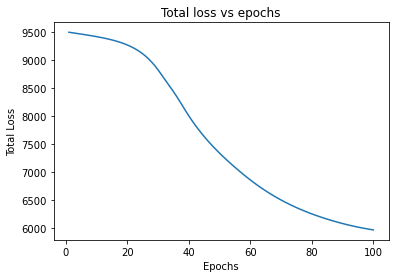

In [46]:
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), losses)
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.title("Total loss vs epochs")
plt.show()

In [43]:
def plot_embeddings_word2vec(model, words):
  
    for word in words:
        embedding = model.get_word_emdedding(word).detach().numpy()
        embedding = embedding.flatten()
        x = embedding[0]
        y = embedding[1]
        plt.title("Plot visualizing word embeddings from Word2Vec")
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize = 9)
    # ------------------

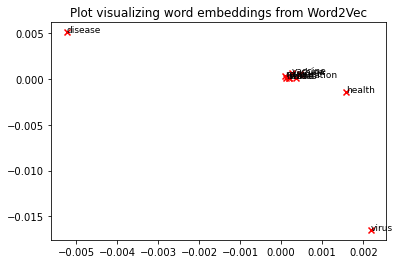

In [44]:
words = ['vaccine', 'china','mutation', 'virus','health', 'disease', 'swine', 'migrant', 'herd', 'illness']
plot_embeddings_word2vec(model, words)

### Selecting ten words from the corpus and listing their syntactic (associative) and semantic similarities

In [41]:
from numpy.linalg import norm

def compute_nearest_word(model, word, word_to_ix, topn):
    """
    :param X: Embedding Matrix |V x D|
    :param idx: The Knn of the ith
    :param k: k nearest neighbour
    :return:
    """
    X = model.embeddings.weight.detach().cpu().numpy()
    idx = word_to_ix[word]
    
    # cosine similarity score
    dists = np.dot(X , X[idx])/(norm(X)*norm(X[idx]))
    idxs = np.argsort(dists)[::-1][:topn + 1]

    print('The {} nearest neighbour of {} are: '.format(str(topn), word))
    for i in idxs[1: ]:
        print("'",list(word_to_ix.keys())[list(word_to_ix.values()).index(i)],"' with a cosine similarity score of", dists[i])
    print("====================")
    return idxs

In [42]:
words = ['vaccine', 'china','mutation', 'virus','health', 'disease', 'swine', 'migrant', 'herd', 'illness']
for word in words:
    compute_nearest_word(model, word, word_to_ix, topn = 10)

The 10 nearest neighbour of vaccine are: 
' cell ' with a cosine similarity score of 0.054032553
' surface ' with a cosine similarity score of 0.05294575
' fipv ' with a cosine similarity score of 0.052354477
' antigen ' with a cosine similarity score of 0.047146544
' infected ' with a cosine similarity score of 0.046524916
' virus ' with a cosine similarity score of 0.03735571
' cat ' with a cosine similarity score of 0.032049745
' positive ' with a cosine similarity score of 0.029134123
' staining ' with a cosine similarity score of 0.0267768
' antibody ' with a cosine similarity score of 0.024590747
The 10 nearest neighbour of china are: 
' health ' with a cosine similarity score of 0.011200807
' south ' with a cosine similarity score of 0.01035968
' coronavirus ' with a cosine similarity score of 0.009983495
' province ' with a cosine similarity score of 0.009606646
' east ' with a cosine similarity score of 0.009227037
' wuhan ' with a cosine similarity score of 0.009055098
' coun